# Assignment-11: Autoencoder

### Name: Ruchitha
### UID: U70955896

## MNIST Data set with existing encoder .h5

Introduction:

In this Note Book, I'll train an autoencoder to reconstruct handwritten digits from the MNIST dataset and include my custom handwritten character, "R." First, I'll create and add five 28x28 pixel images of "R" to the dataset. Then, I'll load the MNIST data and an existing autoencoder model. After evaluating its performance, I'll train a new autoencoder using the augmented dataset, aiming to accurately reconstruct digits and my custom character. Finally, I'll demonstrate the new model's capability to recreate both digits and "R." Let's begin!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Load the supplied autoencoder model
autoencoder = load_model('initially_trained_autoencoder.h5')

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


### showing test images from MNIST data set

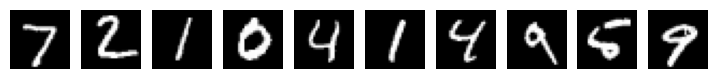

In [ ]:
from matplotlib import pyplot as plt

n = 10
plt.figure(figsize=(9, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
  ax.axis('off')

plt.show()

## Predicting the images with existing encoder .h5

313/313 [==============================] - 4s 10ms/step


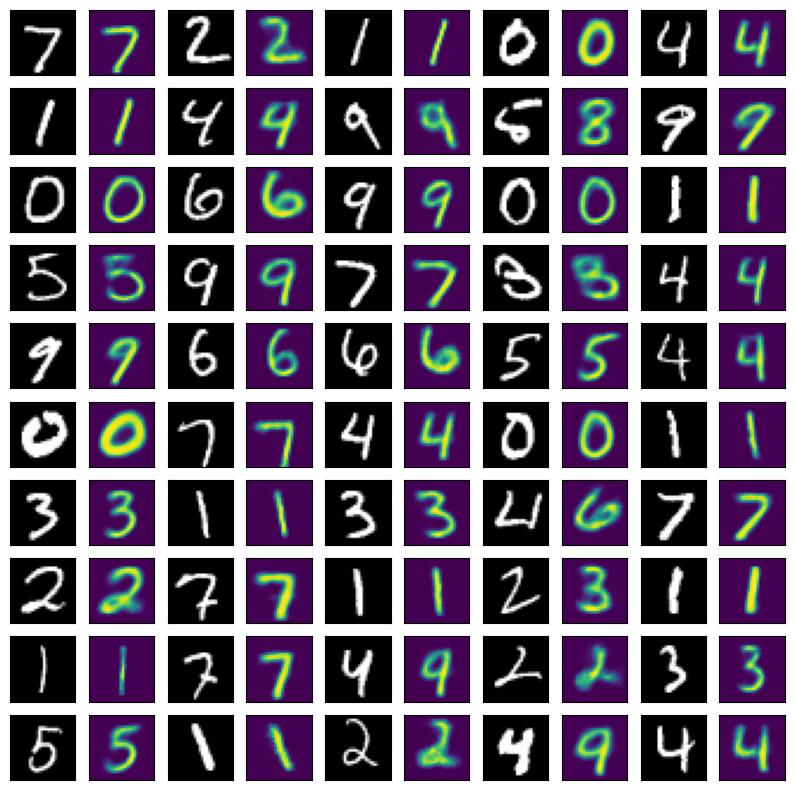

In [ ]:
reconstructed_images = autoencoder.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

## Loading 5 images of letter R

In [ ]:
new_images = []

for i in range(1, 6):
    img_path = f'R{i}.png'
    img = plt.imread(img_path)

    # Convert to grayscale if image is RGB
    if len(img.shape) == 3:  # Check if the image is RGB
        img = np.mean(img, axis=2)  # Convert RGB to grayscale

    img = img.reshape((28 * 28)) / 255.0
    new_images.append(img)

new_images = np.array(new_images)


### Oversampling New Images to Match MNIST Dataset Size

In [ ]:
# Oversample new images to match the size of the MNIST dataset
oversampled_images = np.repeat(new_images, 6000, axis=0)
oversampled_test_images = np.repeat(new_images, 1000, axis=0)

## Conacating MNIST images and new over sampled images

In [ ]:
# Concatenate oversampled images with MNIST dataset
total_train_images = np.concatenate((train_images, oversampled_images), axis=0)
total_test_images = np.concatenate((test_images, oversampled_test_images), axis=0)

### Creating new Autoencoder Architecture Definition and Compilation

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

input_dim = 28*28
latent_vec_len = 16 # this is the 'bottleneck' of the autoencoder

# Define the autoencoder architecture
# build the encoder
autoencoder = Sequential()
autoencoder.add(Input(shape=(input_dim,)))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(100, activation='relu'))

# the bottleneck layer
autoencoder.add(Dense(latent_vec_len, activation='relu'))

# the decoder layer
autoencoder.add(Dense(100, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

# NOTE: The output layer of a Keras autoencoder includes a sigmoid activation function
# because it forces the output to be in the range. This is done to ensure that the
# output can be interpreted as a probability or a pixel intensity of a grayscale image.

# Compile the autoencoder model
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# Get summary
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 16)                1616      
                                                                 
 dense_4 (Dense)             (None, 100)               1700      
                                                                 
 dense_5 (Dense)             (None, 300)               30300     
                                                                 
 dense_6 (Dense)             (None, 500)               1

## Train the newly created_autoencoder

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training


# Train the autoencoder with MNIST data
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = autoencoder.fit(
    x=total_train_images, # For autoencoders, both the input and the target are the same
    y=total_train_images,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(total_test_images, total_test_images),
    callbacks=[early_stop]
)


Epoch 1/10
704/704 [==============================] - 28s 34ms/step - loss: 0.1350 - val_loss: 0.0927
Epoch 2/10
704/704 [==============================] - 24s 34ms/step - loss: 0.0848 - val_loss: 0.0794
Epoch 3/10
704/704 [==============================] - 24s 34ms/step - loss: 0.0768 - val_loss: 0.0739
Epoch 4/10
704/704 [==============================] - 25s 35ms/step - loss: 0.0726 - val_loss: 0.0712
Epoch 5/10
704/704 [==============================] - 25s 36ms/step - loss: 0.0701 - val_loss: 0.0699
Epoch 6/10
704/704 [==============================] - 25s 36ms/step - loss: 0.0684 - val_loss: 0.0683
Epoch 7/10
704/704 [==============================] - 26s 38ms/step - loss: 0.0671 - val_loss: 0.0668
Epoch 8/10
704/704 [==============================] - 25s 35ms/step - loss: 0.0661 - val_loss: 0.0663
Epoch 9/10
704/704 [==============================] - 25s 35ms/step - loss: 0.0654 - val_loss: 0.0656
Epoch 10/10
704/704 [==============================] - 25s 35ms/step - loss: 0.064

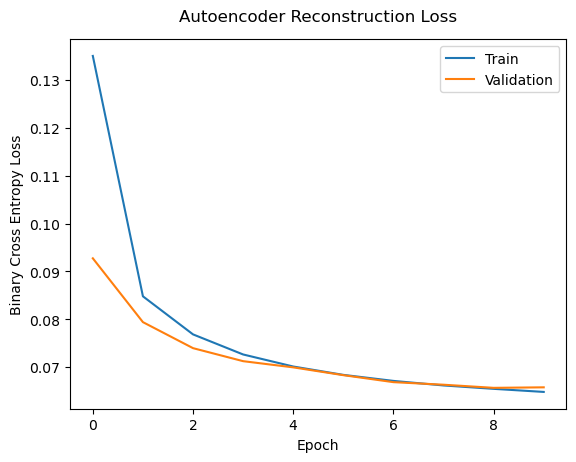

In [ ]:
# Plot training and validation loss scores
# against the number of epochs.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Autoencoder Reconstruction Loss', pad=13)
plt.legend(loc='upper right')

469/469 [==============================] - 4s 8ms/step


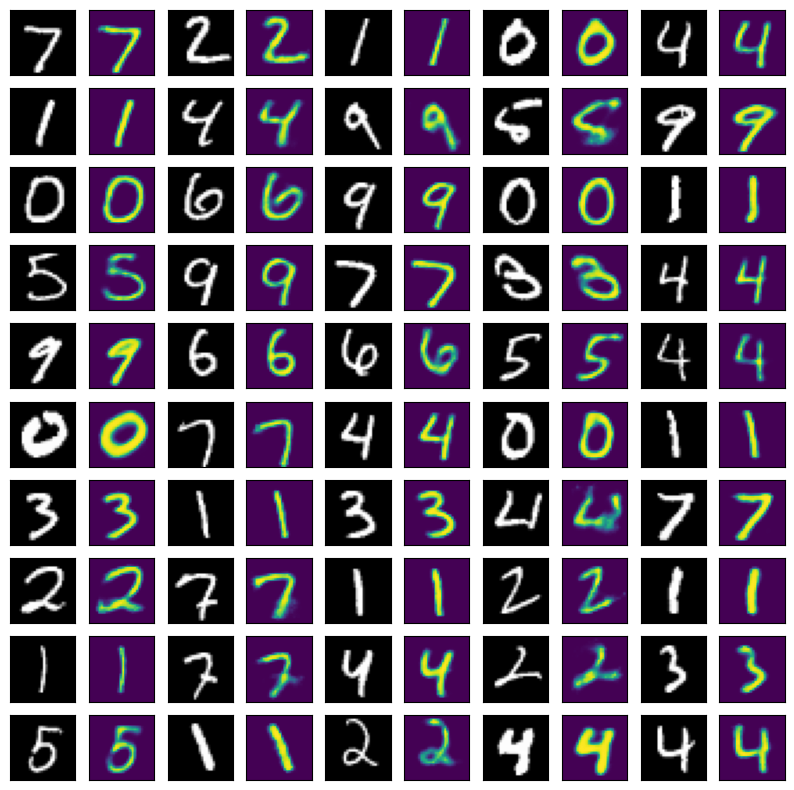

In [ ]:
reconstructed_images = autoencoder.predict(total_test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Saving the new auto encoder

In [ ]:
autoencoder.save('initially_trained_autoencoder_with_image_r.h5')

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Reconstruction Comparison Between Original and Reconstructed Images

1/1 [==============================] - 0s 57ms/step


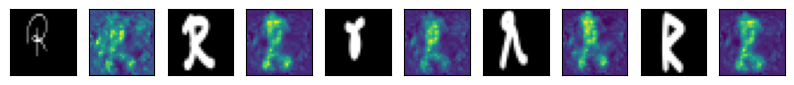

In [ ]:
reconstructed_images = autoencoder.predict(new_images)

images = []
for i in range(5):
    images.append(new_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 1
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

Conclusion:

Through this project, I successfully integrated my custom handwritten character into the MNIST dataset and trained an autoencoder to reconstruct it alongside the standard digits. The process involved creating and oversampling five images of the letter "R" and incorporating them into the training data. After training the new autoencoder model, it demonstrated proficiency in reconstructing both digits and my custom character. This project highlights the adaptability of autoencoder models and the potential for customizing them to suit specific tasks. Moving forward, further refinement and experimentation could enhance the model's performance and expand its applicability to diverse datasets and tasks. Overall, this project serves as a practical demonstration of leveraging autoencoders for image reconstruction tasks and underscores the versatility of machine learning techniques in accommodating custom requirements.